Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1218/1218 [==============================] - 8s 7ms/step - loss: 0.0677
Epoch 2/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0080
Epoch 3/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0080
Epoch 4/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0079
Epoch 5/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0068
Epoch 6/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0063
Epoch 7/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0065
Epoch 8/100
1218/1218 [==============================] - 3s 3ms/step - loss: 0.0066
Epoch 9/100
1218/1218 [==============================] - 4s 3ms/step - loss: 0.0063
Epoch 10/

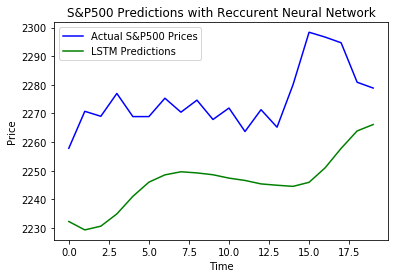

In [2]:
import numpy as np
import pandas as pd 
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#------------ FETCHING AND PREPROCESSING THE DATA ----------------

#we have a dataset for training and distinct dataset for testing
prices_dataset_train =  pd.read_csv('SP500_train.csv')
prices_dataset_test =  pd.read_csv('SP500_test.csv')


# Let’s briefly describe data features. 
#Open is the price of the stock at the beginning of the trading day 
#(it need not be the closing price of the previous trading day), 
#high is the highest price of the stock on that trading day,
#low the lowest price of the stock on that trading day, and close the price of the stock at closing time. 
#Volume indicates how many stocks were traded. 
#Adjusted close is the closing price of the stock that adjusts the price of the stock for corporate actions. 
#While stock prices are considered to be set mostly by traders, 
#stock splits (when the company makes each extant stock worth two and halves the price) and 
#dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.
#we are after a given column in the dataset
trainingset = prices_dataset_train.iloc[:,5:6].values
testset = prices_dataset_test.iloc[:,5:6].values

#we use min-max normalization to normalize the dataset
min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaled_trainingset = min_max_scaler.fit_transform(trainingset)

#we have to create the training dataset because the features are the previous values
#so we have n previous values: and we predict the next value in the time series
X_train = []
y_train = []

for i in range(40,1258):
    #0 is the column index because we have a single column
    #we use the previous 40 prices in order to forecast the next one
    X_train.append(scaled_trainingset[i-40:i,0]) 
    #indexes start with 0 so this is the target (the price tomorrow)
    y_train.append(scaled_trainingset[i,0])
 
#we want to handle numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

#input shape for LSTM architecture
#we have to reshape the dataset (numOfSamples,numOfFeatures,1)
#we have 1 because we want to predict the price tomorrow (so 1 value)
#numOfFeatures: the past prices we use as features
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

#------------ BUILDING THE LSTM MODEL ----------------

#let's build the LSTM architecture
#return sequence true because we have another LSTM after this one
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.5))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(units=1))

#RMSProp is working fine with LSTM but so do ADAM optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

#------------ TESTING THE ALGORITHM ----------------
#training set plus testset
dataset_total = pd.concat((prices_dataset_train['adj_close'],prices_dataset_test['adj_close']), axis=0) #vertical axis=0 horizontal axis=1
#all inputs for test set
inputs = dataset_total[len(dataset_total)-len(prices_dataset_test)-40:].values
inputs = inputs.reshape(-1,1)

#neural net trained on the scaled values we have to min-max normalize the inputs
#it is already fitted so we can use transform directly
inputs = min_max_scaler.transform(inputs)      

X_test = []

for i in range(40,len(prices_dataset_test)+40):
    X_test.append(inputs[i-40:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

#inverse the predicitons because we applied normalization but we want to compare with the original prices
predictions = min_max_scaler.inverse_transform(predictions)

#plotting the results
plt.plot(testset, color='blue', label='Actual S&P500 Prices')
plt.plot(predictions, color='green', label='LSTM Predictions')
plt.title('S&P500 Predictions with Reccurent Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()